In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

In [3]:
from sklearn.metrics import accuracy_score
import random

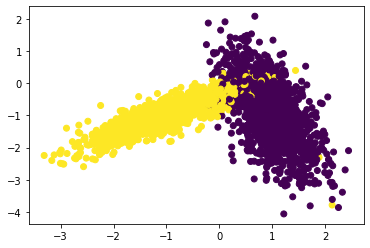

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [5]:
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
  dicti = dict() #dicti's (key, value): key represent ith fold and its value represents list of all indices ith fold holds
  indices = range(len(x_train)) # values in this array are sorted 
  #np.random.shuffle(indices) #valus in the array have been shuffled randomly, but it is not using uniform sampling
  #i am using random.sample , therefore. I didnot get which distribution does it use , from internet.
  #will try to write a function for that.
  indices = random.sample(indices,len(x_train))
  m = 1/folds
  for i in range(folds):
    start = int(i*m*len(x_train))
    end = int((i+1)*m*len(x_train))
    dicti[i] = indices[start:end]
  
 
  train_acc = []
  cv_acc = []

  start = param_range[0] # we are assigning start variable to the start value in the range given by user

  if start %2 ==0: # if the start is even , we increment start by 1 to facilitate taking only odd values of k's 
    start += 1

  if start < 0:
    start = 1

  if param_range[0] > param_range[1]:
    print("check param_range")
    return ("bad","param_range","given")

  array = range(start, param_range[1]+1, 2)#modified to bear only odd numbers
  #print(array)
  params = random.sample(array,10)
  #print(params)

  

  super = set(np.arange(len(x_train))) # set of all the indices possible for x_train
  
  for par in params:
    for i in range(folds):
      temp_train_acc = []
      temp_cv_acc = []

      my_cv = x_train[dicti[i]] #dicti[i] holds a list of indices, we extracted values from x_train corresponding to dicti[i],and this becomes my cv_Data
      my_ground = y_train[dicti[i]] # same logic and we get corresponding y's(ground_truths)
      
      remaining_indices = list(super - set(dicti[i])) #remaining all the indices correspond to values belonging to my train_data


      train_x = x_train[remaining_indices]
      train_y = y_train[remaining_indices]
      
      classifier.n_neighbors = par # this is the hyperparam assignment
      classifier.fit(train_x,train_y)

      y_hat = classifier.predict(train_x)
      temp_train_acc.append(accuracy_score(train_y, y_hat))
      temp_cv_acc.append(accuracy_score(my_ground,classifier.predict(my_cv)))

    train_acc.append(np.array(temp_train_acc).mean())
    cv_acc.append(np.array(temp_cv_acc).mean())

  return cv_acc, train_acc, params


In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
x_train=scaler.transform(X_train)
x_test = scaler.transform(X_test)

clf = KNeighborsClassifier()
#params = [3,5,7,9,11,13,15,17,19,21,23]
params = (2,50)

cv_acc_lst, train_acc_lst, params = RandomSearchCV(x_train,y_train,clf,params, 3)

#tuple params_range has restrictions. The lower_bound should be > 0 




In [8]:
train_acc_lst = [t for _, t in sorted(zip(params, train_acc_lst))]
cv_acc_lst = [cv for _, cv in sorted(zip(params, cv_acc_lst))]
 # ["a", "d", "h", "b", "c", "e", "i", "f", "g"]

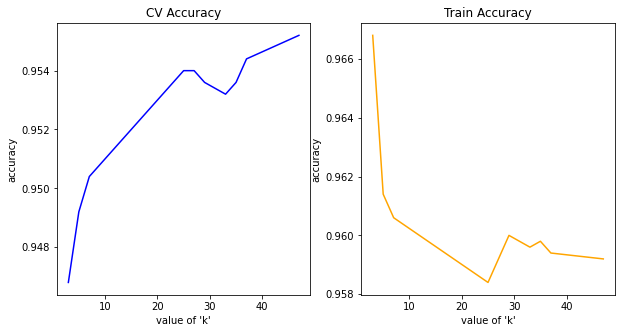

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot( sorted(params), cv_acc_lst, c='b') # with line plot , it comes a bit arbitrary lines
ax[0].set_xlabel("value of 'k'")
ax[0].set_ylabel("accuracy")
ax[0].set_title("CV Accuracy")
ax[1].plot(sorted(params), train_acc_lst, c='orange')
ax[1].set_xlabel("value of 'k'")
ax[1].set_ylabel("accuracy")
ax[1].set_title("Train Accuracy")
plt.show()

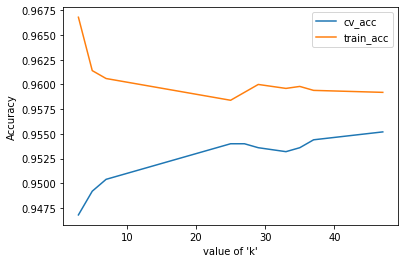

In [14]:
plt.plot(sorted(params), cv_acc_lst, label='cv_acc')
plt.plot(sorted(params), train_acc_lst, label ='train_acc')
plt.xlabel("value of 'k'")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
cv_acc_lst = np.array(cv_acc_lst)
train_acc_lst = np.array(train_acc_lst)

k_min_diff = sorted(params)[np.argmin(np.abs(cv_acc_lst - train_acc_lst))] #extracting k for which difference between the accuracies is minimum
#it is advisible to check if this k also giving good enough values of accuracies, visually

sorted(params)

[3, 5, 7, 25, 27, 29, 33, 35, 37, 47]

In [11]:
#when my values of k is [24 46 28 10 16 44 40  8 34 14],i.e even k's, 
#what a haphazard!, neither cv_acc nor train_acc seems following a curve unlike when k's were odd.
#i.e considering train_acc, there's increase initially from k=8 to k=14 , then decrease , then increase followed by 
#decrease again, and again increse
#also, some increase seems sharp,i.e, it doesn't seem smooth changes along the way.
#cv_acc plot behaves better than train_acc plot. But, comparing with the previous curves with a set of even k's , we can 
#conclude that teh curves aren't following same pattern

#when my values of k is [ 2 36 14 26 44 40 32 30 10 28],i.e even k's, then we see nice curves interaction as we witnessed when k were odd
#so, the behaviour of curves seem unstable with even k's


In [21]:
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

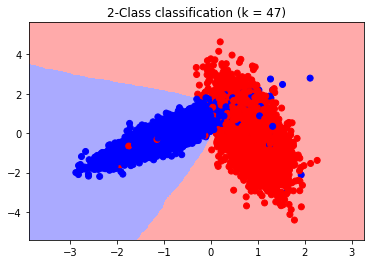

In [22]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = k_min_diff)
neigh.fit(x_train, y_train)
plot_decision_boundary(x_train[:, 0], x_train[:, 1], y_train, neigh)